# Ultimate Inc

## Part 1 of Data Science Challenge

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location.
Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.
Please report/illustrate important features of the demand, such as daily cycles. 
If there are data quality issues, please report them.

In [129]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [130]:
df = pd.read_json('logins.json')
df.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


### Wrangling Data

Will be working with data that will require time series analysis.
In some cases I'd reach out to the interviewer (or business analyst) to see if a specific time series library was preferred by the company/team.
In this case, assuming the challenge is expected to be solved without using these types of libraries.

In [131]:
# Has 1 column and 90k+ rows.
df.shape

(93142, 1)

In [132]:
# Checking for missing values
df.isnull().sum()

login_time    0
dtype: int64

In [133]:
# Converting to a datetime format
df['login_time'] = pd.to_datetime(df['login_time'])
df.sort_values('login_time')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [134]:
# Checking to see if login_time is unique so it can be used as the index.
df['login_time'].nunique()

92265

877 are NOT unique (less than 1%).

Since this is simulated data will drop these values and then set the index to the login_time.
However, may not do this on a real project because these could be different users that are logged in at the exact same time because we only have date times that go to the second.

In [135]:
df.drop_duplicates(inplace=True)
df.shape

(92265, 1)

In [136]:
# Checking time ranges.

print(f"First date: {df['login_time'].min()}.")
print(f"Last date: {df['login_time'].max()}.")

First date: 1970-01-01 20:12:16.
Last date: 1970-04-13 18:57:38.


In [137]:
# Create new columns
# This default value will change in calculations later.
df['login_count'] = 1
# Separating out the various time components by referencing https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-components
df['year'] = df['login_time'].dt.year
df['month'] = df['login_time'].dt.month
df['day'] = df['login_time'].dt.day
df['hour'] = df['login_time'].dt.hour
df['minute'] = df['login_time'].dt.minute
df['second'] = df['login_time'].dt.second
# Monday=0, Sunday=6
df['day_of_week'] = df['login_time'].dt.day_of_week
# Changed pattern because weekofyear is deprecated
df['week_of_year'] = df['login_time'].dt.isocalendar().week
df['day_of_year'] = df['login_time'].dt.day_of_year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92265 entries, 0 to 93141
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   login_time    92265 non-null  datetime64[ns]
 1   login_count   92265 non-null  int64         
 2   year          92265 non-null  int64         
 3   month         92265 non-null  int64         
 4   day           92265 non-null  int64         
 5   hour          92265 non-null  int64         
 6   minute        92265 non-null  int64         
 7   second        92265 non-null  int64         
 8   day_of_week   92265 non-null  int64         
 9   week_of_year  92265 non-null  UInt32        
 10  day_of_year   92265 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int64(9)
memory usage: 8.2 MB


In [138]:
df = df.set_index('login_time')
df.value_counts()

login_count  year  month  day  hour  minute  second  day_of_week  week_of_year  day_of_year
1            1970  1      1    20    12      16      3            1             1              1
                   3      16   3     19      5       0            12            75             1
                                     11      51      0            12            75             1
                                     9       54      0            12            75             1
                                             50      0            12            75             1
                                                                                              ..
                   2      13   19    41      59      4            7             44             1
                                     39      13      4            7             44             1
                                     38      33      4            7             44             1
                                   

In [139]:
# Create new dataframe for grouping by 15 minutes.
df_15_min = pd.DataFrame(df['login_count'].resample('15Min').sum())
df_15_min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [140]:
df_15_min.value_counts()

login_count
2              728
4              711
3              705
5              660
1              638
              ... 
53               1
54               1
50               1
49               1
68               1
Length: 61, dtype: int64

### Visualize Data

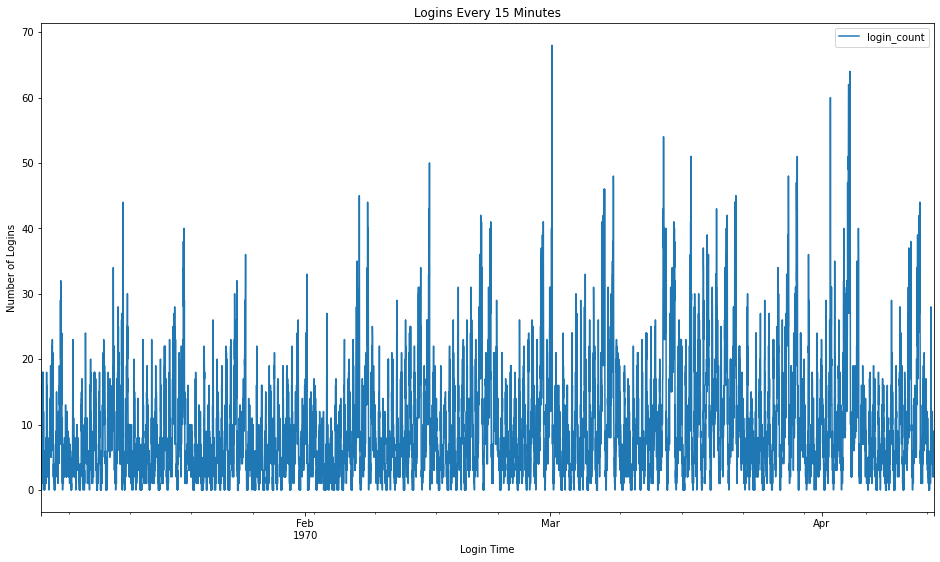

In [141]:
df_15_min.plot(figsize=(16, 9))
plt.title('Logins Every 15 Minutes')
plt.xlabel('Login Time')
plt.ylabel('Number of Logins')
plt.show()

Can see that there are clear patterns here. 
Notes: 
- The analysis assumes all the times are already standardized to the same time zone.
- If this was financial data that we were using to make predictions it should be cleaned further to remove cyclical / seasonal variations.

In [144]:
def create_bar_plot(func_, list_):
    """
    Create a plot for data visualization using time series components.
    :param func_: Seaborn function to display the data (i.e. 'sns.barplot').
    :param list_: List of the desired data values (i.e. df.index.hour) and it's label (i.e. 'hour').
    :return: Displays the desired plot for the dataframe.
    """
    plt.figure(figsize=(16, 9))
    func_(x=list_[0], y=df_15_min.login_count, data=df_15_min)
    
    plt.title(f"Number of Logins by {list_[1]}.")
    plt.xlabel(list_[1])
    plt.ylabel('Number of Logins')
    plt.show()
    

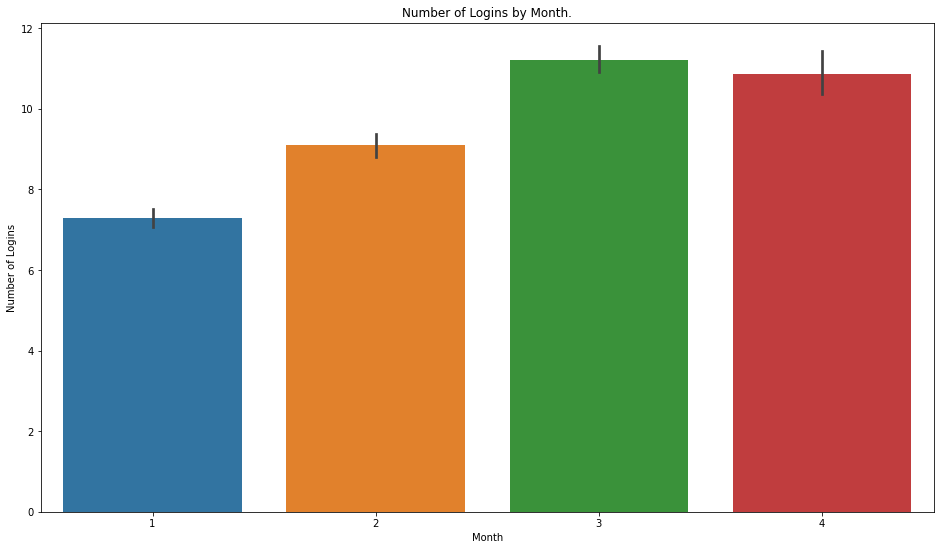

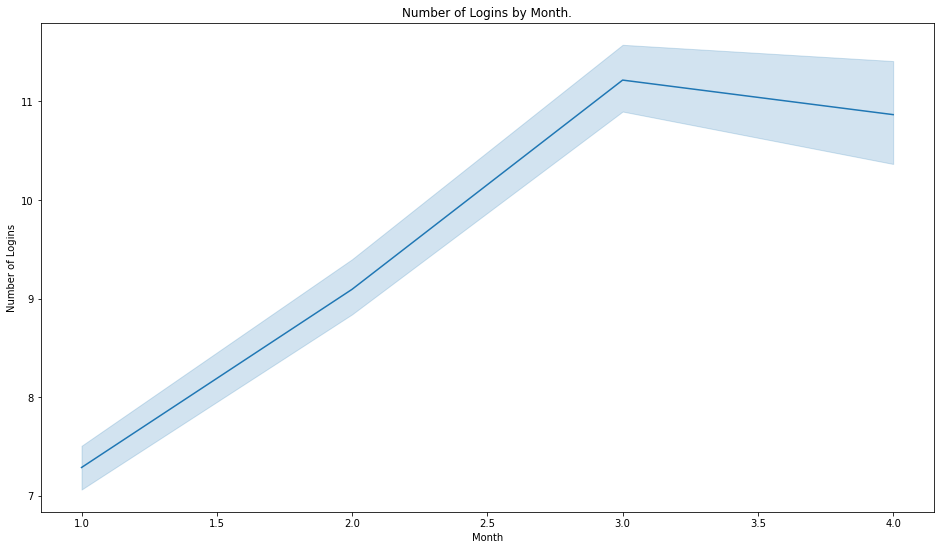

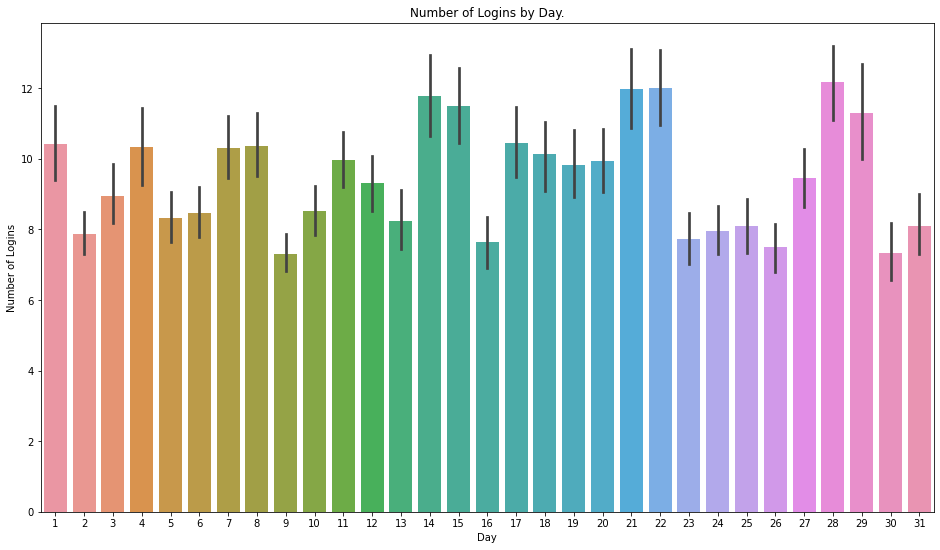

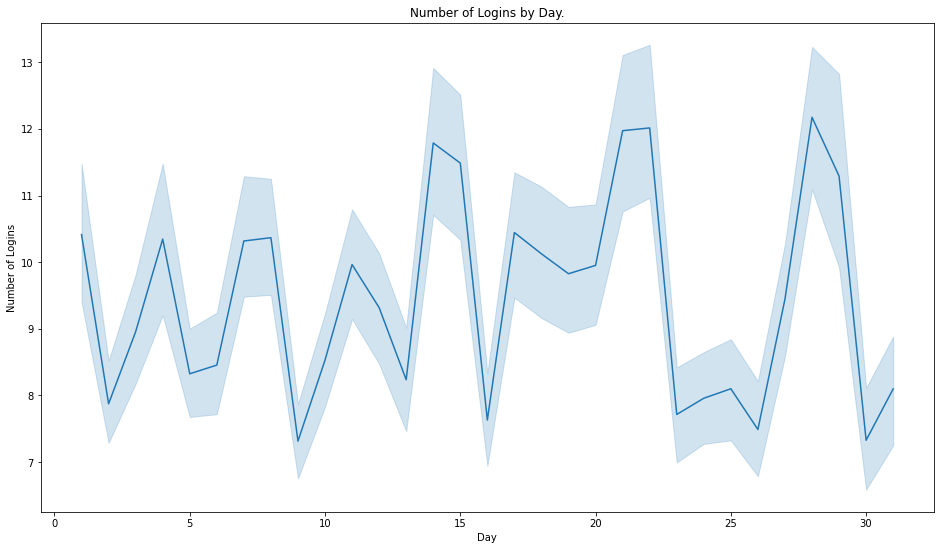

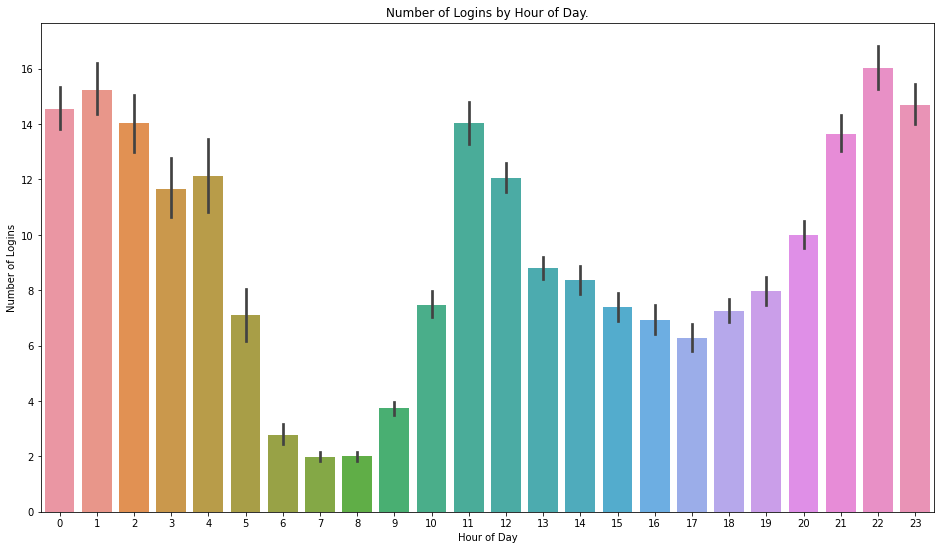

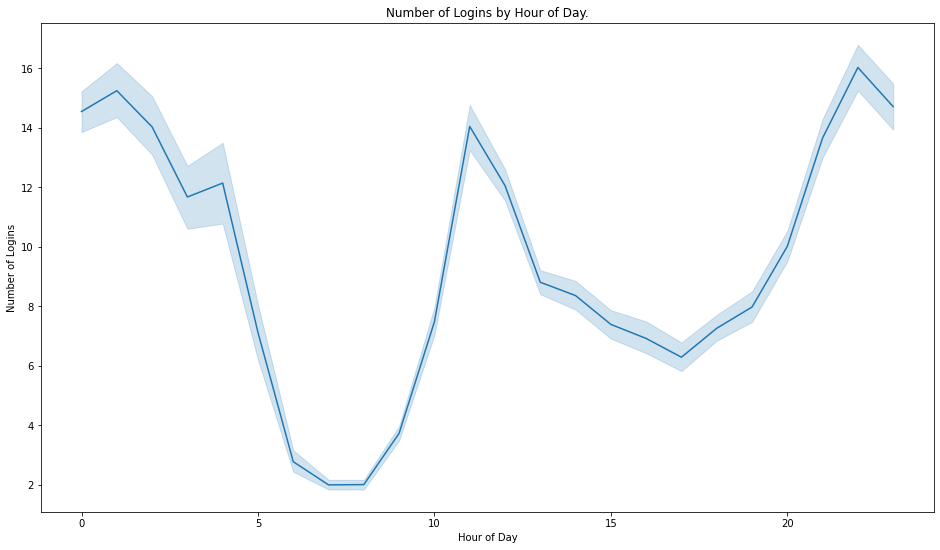

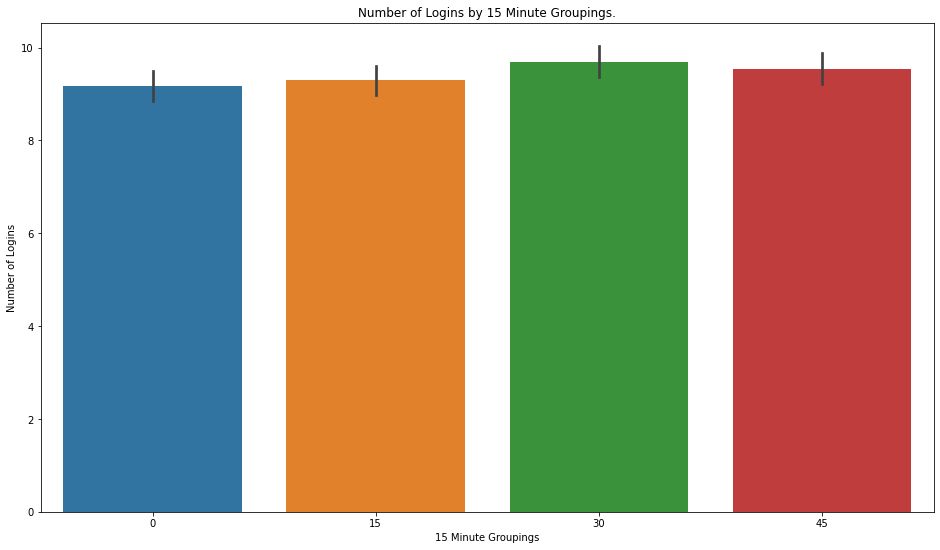

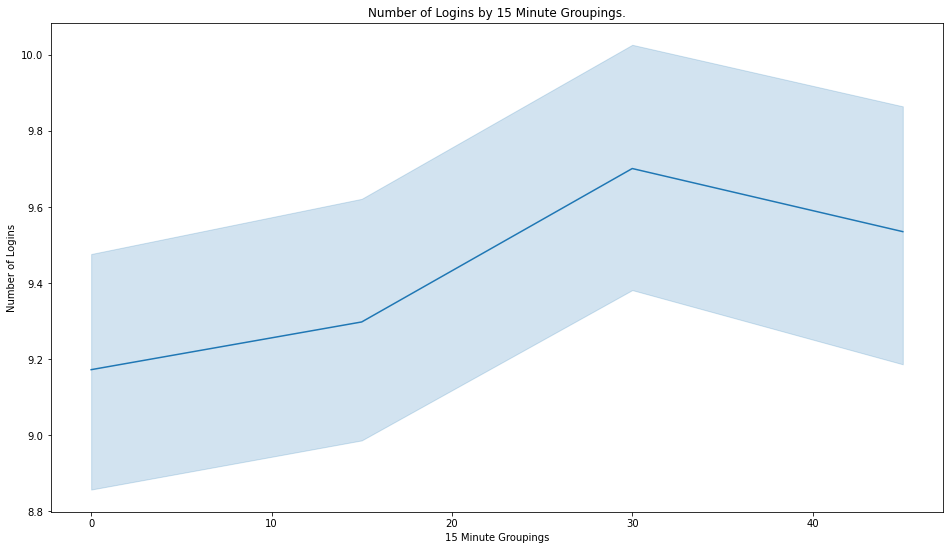

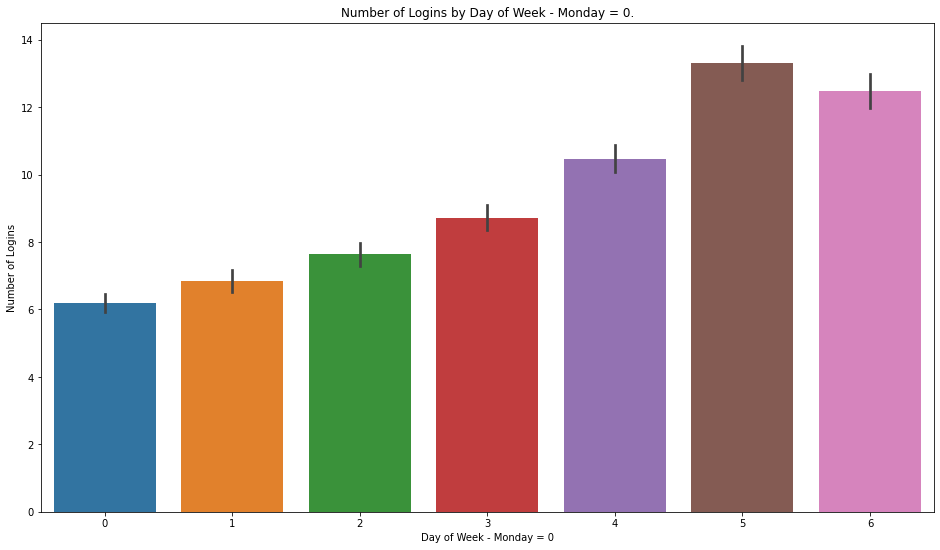

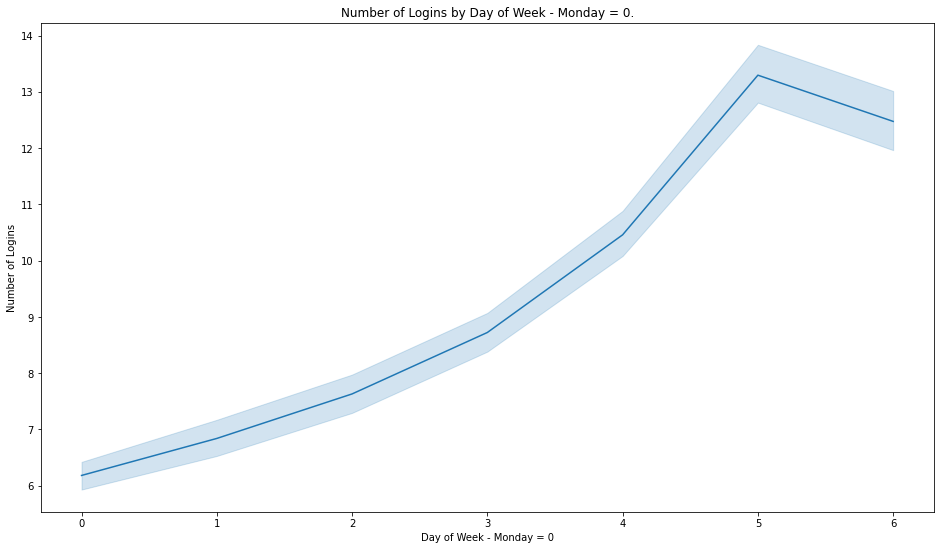

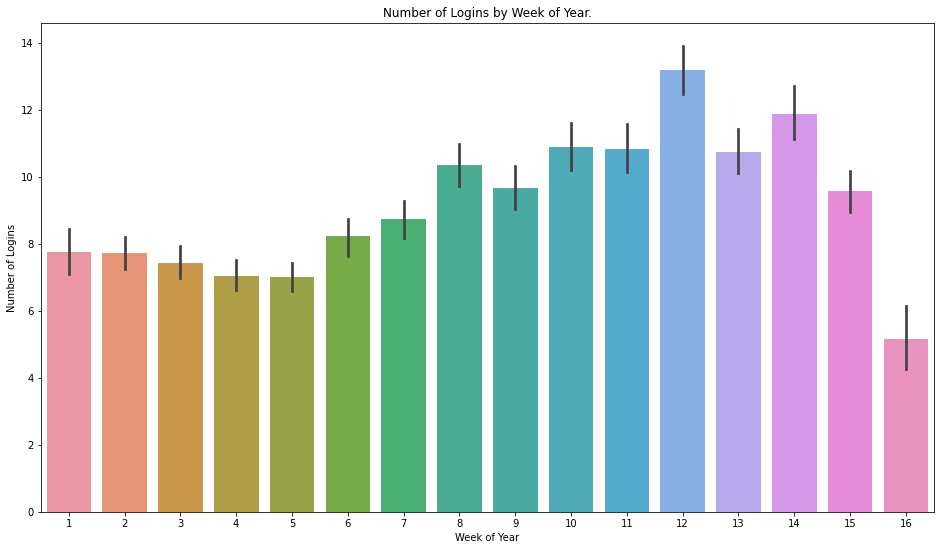

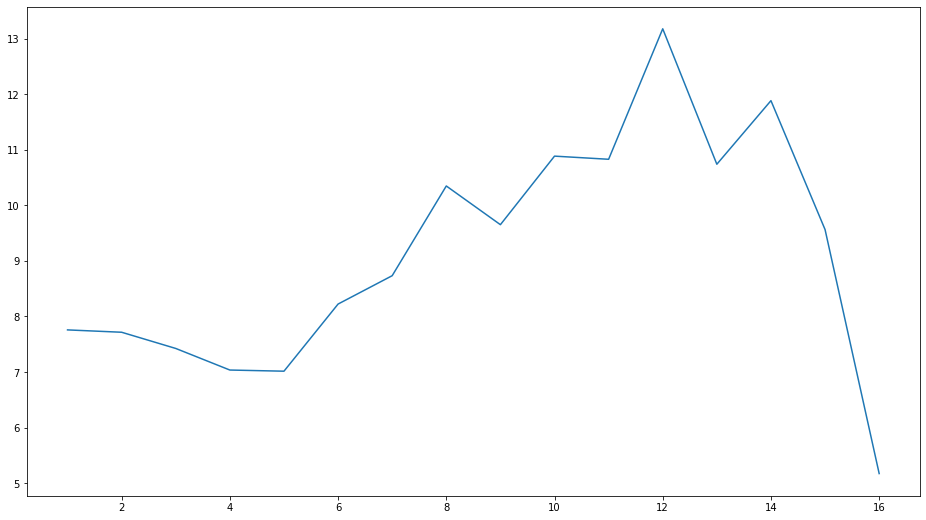

In [147]:
# These results also show several patterns.
time_grouping = [
    [df_15_min.index.month, 'Month'],
    [df_15_min.index.day, 'Day'],
    [df_15_min.index.hour, 'Hour of Day'],
    [df_15_min.index.minute, '15 Minute Groupings'],
    [df_15_min.index.day_of_week, 'Day of Week - Monday = 0'],
    [df_15_min.index.isocalendar().week, 'Week of Year']]

for i in time_grouping:
    create_bar_plot(sns.barplot, i)
    try:
        create_bar_plot(sns.lineplot, i)
    except TypeError:
        # Would log this somewhere usually because errors/exceptions shouldn't be ignored.
        # This is an issue with how the label is being created but it doesn't affect this analysis.
        pass

### Summary
The only issue with the data was the 877 duplicate values. Dropped these values because this project used simulated data.

There were several trends / cyclical patterns in the data. The most visually noticeable were:
- There is a cycle of varying logins based off the time of the day; with the fewest happening in the mornings and afternoons.
- The most logins happen on the weekends.
- There are other patterns that look significant (especially on the line plots); however, the default scales on these graphs sometimes present trends that probably don't matter as much as they appear to.

To improve to this project later on we could use summary statistics to further analyze these results to determine how significant they really are.